# Gem Hunting
I would like to know the relative frequency with which gems drop for various actions (to compare with combat).
Furthermore, I need to determine if the probability is the same for any action in a subset of actions or
weighted by the base time (like naturalist). The modes to study are
1. Foraging (Root digging)
2. Mining (default)
3. Mining (prospector)
4. Smithing (refining)

#### Foraging (100 gems each)
- [ ] Grasslands (high stats)
- [x] Fungal Grotto
- [x] Haunted (fewer gems)

#### Mining (100 gems base, 10% uncertainty on snr)
- [x] Clay pit (no prospector)
- [x] Clay pit (with prospector)

#### Smithing (all ore from above, hopefully enough stats)
- [ ] Bronze
- [ ] Rune, Mith, Addy

## Prior
It has been stated that for certain actions, the gem drop distribution is `gem_dist = [40, 30, 20, 7, 3]`, and that the
roll is `if( rndm() < gem_chance ) then choice(gem_dist)` so our test statistic can be on total number of gems
rather than sampling each gem independently. With enough data we may be able to test this hypothesis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as fit
from rootprospect import *
plt.style.use("seaborn-dark-palette")

## Foraging Data

Fungal
Gem Probability: 0.00023 +- 0.00003
Action-enchant per gem: 4279.09 + 531.21 - 425.55

Haunted
Gem Probability: 0.00024 +- 0.00004
Action-enchant per gem: 4244.51 + 948.02 - 655.30

Grasslands
Gem Probability: 0.00021 +- 0.00002
Action-enchant per gem: 4729.48 + 395.39 - 338.75

Combined Results
Gem Probability: 0.00022 +- 0.00001
Action-enchant per gem: 4545.62 + 288.92 - 256.33

Gem drop distribution χ^2: 0.32


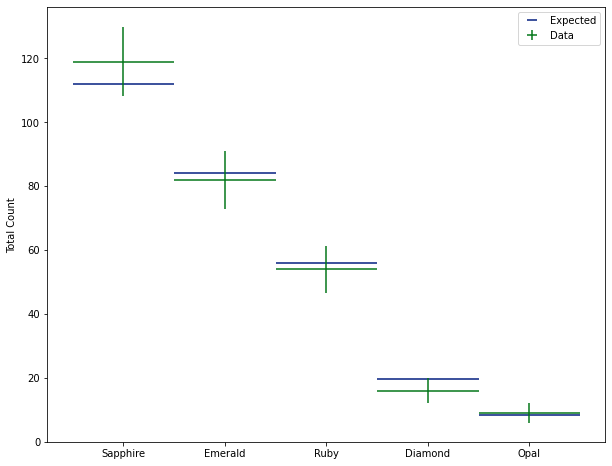

In [2]:
'''
Data collection
'''
## FG
fungal = GemGatherData()
fungal.setActionsFromDeltaTime(1620419087, 1620574242, actionTimer(8, 176, 6))
fungal.setGems([34, 28, 13, 3, 4])
print("Fungal")
fungal.report()

## Haunted
haunted = GemGatherData()
haunted.setActionsFromDeltaTime(1620593916, 1620699106, actionTimer(15, 177, 6))
haunted.setGems([12, 9, 6, 2, 1])
print("\nHaunted")
haunted.report()

## Grasslands
grass = GemGatherData()
grass.setActionsFromDeltaTime(1620707472, 1620969072, actionTimer(6, 178, 6))
grass.setGems([73, 45, 35, 11, 4])
print("\nGrasslands")
grass.report()

combined = fungal + haunted + grass
print("\nCombined Results")
combined.report()

print(f'\nGem drop distribution χ^2: {gemChi2(combined, plot=True):0.2f}')

### Is the probability scaled by base time directly?
Root digging, base timer adjusted hypothesis. This test is to determine if the probability is adjusted
by the base timer in the same way that naturalist is ie `base_time * probability`. This would mean that
the rate of gem drops (per unit time) would be the same across all zones. The data disfavors this particular
hypothesis; however, we have information that the rate scales "a bit" with base time.

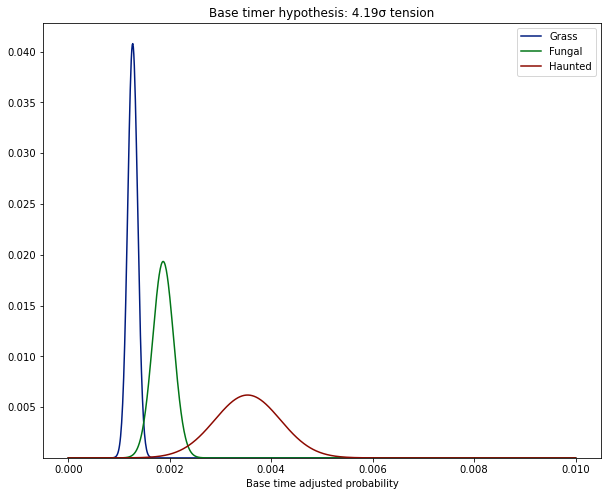

In [3]:
baseTimerHypothesis([grass, fungal, haunted], [6, 8, 15], ["Grass", "Fungal", "Haunted"])
#baseTimerHypothesis([grass, haunted], [6, 15], ["Grass", "Haunted"])
plt.show()

## Base scale linear?

3.1014691092802997e-06 0.00019663667931482206


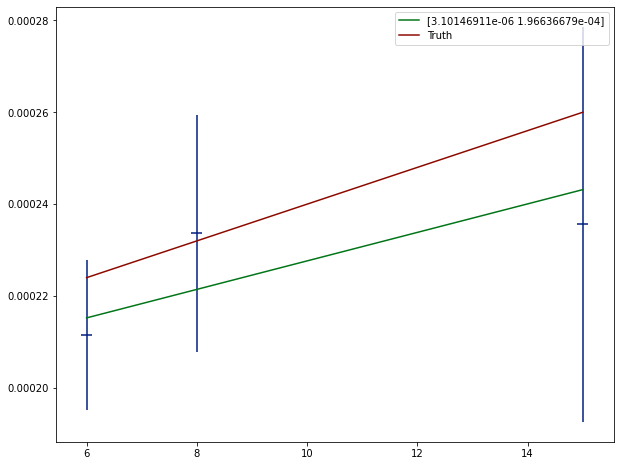

In [9]:
#basetimes = np.array([6, 8, 15])
#scale = 30/(basetimes*0.001 + 1)
#scale = 1/(basetimes*0.01+1)
#baseTimerHypothesis([grass, fungal, haunted], scale, ["Grass", "Fungal", "Haunted"])
#plt.xlim(0,0.0005)
#plt.show()
def baseTimerFit(ggd, timers, names, **kwargs):
    f = kwargs.get("f", lambda x, a, b: a*x +b)
    #f = lambda x, a, b: a*x + b
    fig = plt.figure(figsize=(10,8))
    x, y, yerr = [], [], []
    for (g, t, n) in zip(ggd, timers, names):
        ymn, yup = g.getActionProbability()
        x.append(t)
        y.append(ymn)
        yerr.append(yup)
    plt.errorbar(x, y, yerr=yerr, xerr=0.1, linestyle="None")
    popt, pcov = fit(f, x, y, sigma=yerr)
    print(*popt)
    plt.plot(x, [f(a,*popt) for a in x], label=f'{popt}')
    return popt, pcov

popt, pcov = baseTimerFit([grass, fungal, haunted], [6, 8, 15], ["Grass", "Fungal", "Haunted"])
## Truth from Kugan (on wiki)
rootdigging = lambda bt, lvl: (bt*2 + lvl*100)/500000
bt = np.linspace(6, 15, 100)
plt.plot(bt, rootdigging(bt, 1), label="Truth")
#baseTimerFit([grass, fungal, haunted], [6, 8, 15], ["Grass", "Fungal", "Haunted"], f=lambda x, a, b, c: a*x**2+b*x+c)
plt.legend()
plt.show()

### Action dependent results
Results for the probability to get a gem per action per level of root-digging. For this we assume
that the probability is directly proportional to the enchant level, and that it is the same for
each zone (seems likely given the above tension, but it could have a small zone dependence). I
also assume that the gem drop distribution of [40, 30, 20, 7, 3] (or some other) holds true in
each zone, so that we can base results on total gem drops and not individual drops.

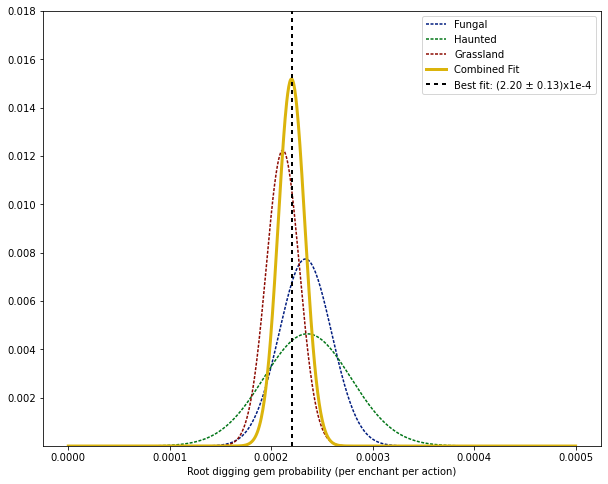

In [5]:
fig = plt.figure(figsize=(10,8))
plotConfidence(fungal,  dashes=[2,1], label="Fungal")
plotConfidence(haunted, dashes=[2,1], label="Haunted")
plotConfidence(grass,   dashes=[2,1], label="Grassland")
m, s = plotConfidence(combined, label="Combined Fit", linewidth=3, color="xkcd:gold")
plt.ylim(top=0.018)
plt.xlabel("Root digging gem probability (per enchant per action)")
plt.axvline(m, color="xkcd:black", label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4', linewidth=2, dashes=[2,2])
plt.legend()
plt.show()

## Mining Data

** Background dataset **
Gem Probability: 0.00023 +- 0.00004
Action-enchant per gem: 4409.07 + 828.06 - 601.96

** Clay Pit Prospect 6 **
Signal Uncertainty: 24.70
Bkg Uncertainty: 15.15
Gem Probability: 0.00020 +- 0.00001
Action-enchant per gem: 4931.34 + 294.52 - 263.09

Gem drop distribution χ^2: 0.58


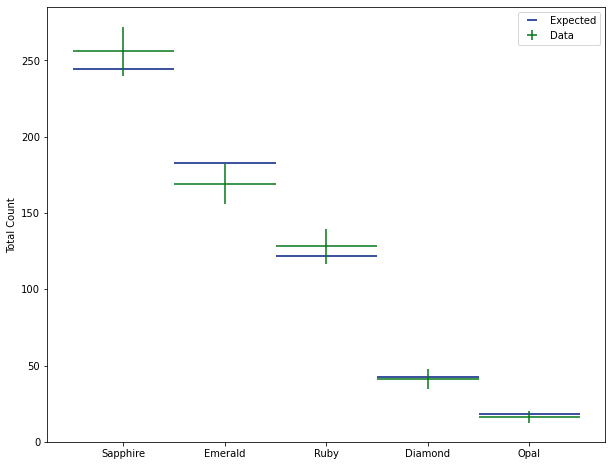

In [6]:
'''
Data Collection: Using essence as mining action proxy.
!-- Pit data is flawed by demon contamination, would need volcano data
'''
pitNoProspectIM = GemGatherData(enchant=1)
pitNoProspectIM.setActionsFromDeltaEssence(1224423, 1367948, elvl=5)
pitNoProspectIM.setGems([3, 2, 3, 0, 0])
#pitNoProspectIM.report()

pitNoProspect = GemGatherData(enchant=1)
pitNoProspect.setActionsFromDeltaEssence(578110, 1008950, elvl=10)
pitNoProspect.setGems([6, 3, 2, 2, 1])
#pitNoProspect.report()

guest = GemGatherData(enchant=1)
guest.setActionsFromDeltaEssence(0, 84890, elvl=1)
guest.setGems([10, 6, 5, 1, 0])

clayNoProspect = GemGatherData(enchant=1)
clayNoProspect.setActionsFromDeltaEssence(1008950, 1923680, elvl=10)
clayNoProspect.setGems([8, 5, 5, 0, 0])

print("** Background dataset **")
combinedNP = clayNoProspect + guest
combinedNP.report()

## Prospector 6
print("\n** Clay Pit Prospect 6 **")
clayProspect = GemGatherData(enchant=6)
clayProspect.setActionsFromDeltaEssence(2058260, 6284060, elvl=10)
clayProspect.setGems(np.array([256, 169, 128, 41, 16]))
clayProspect.setBackgroundDataset(combinedNP, verbose=True)
clayProspect.report()


print(f'\nGem drop distribution χ^2: {gemChi2(clayProspect, plot=True):0.2f}')

4758 ± 204


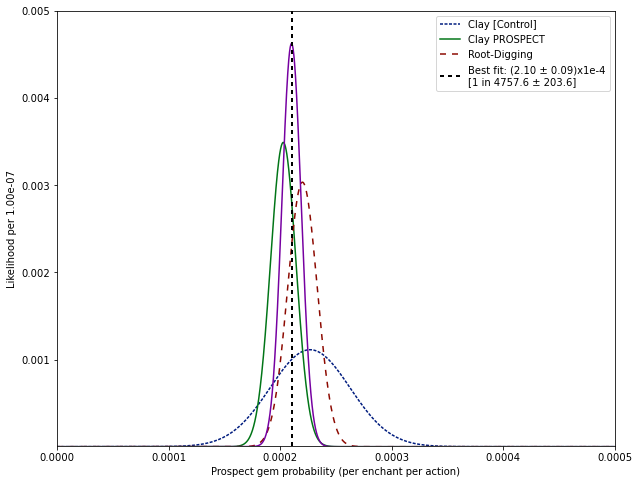

In [7]:
fig = plt.figure(figsize=(10,8))
xbins = np.linspace(0, 1e-3, 10000)
plotConfidence(combinedNP,  dashes=[2,1], label="Clay [Control]", x=xbins)
m, s = plotConfidence(clayProspect,  label="Clay PROSPECT", x=xbins)
m2, s2 = plotConfidence(combined,   dashes=[4,4], label="Root-Digging", x=xbins)
g = lambda x, μ, σ: np.exp(-(x-μ)**2/2/σ**2)/np.sqrt(2*np.pi*σ**2)

z = (g(xbins, m, s) * g(xbins, m2, s2) )
z = z / sum(z)
plt.plot(xbins, z)
m = np.sum(xbins*z)
s = np.sqrt( np.sum((xbins-m)**2*z) )
#m, s = plotConfidence(combinedNP, label="Combined Fit", linewidth=3, color="xkcd:gold", x=xbins)
#plt.axvline(m, color="xkcd:black", label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4', linewidth=2, dashes=[2,2])
plt.ylim(top=0.005)
plt.xlim(0, 0.0005)
label=f'Best fit: ({m * 1e4:0.2f} ± {s * 1e4:0.2f})x1e-4\n[1 in {1/m:0.1f} ± {1/(m-s)-1/m:0.1f}]'
plt.axvline(m, color="xkcd:black", label=label, linewidth=2, dashes=[2,2])
print(f'{1/m:0.0f} ± {1/(m-s)-1/m:0.0f}')
plt.ylabel(f"Likelihood per {xbins[1]-xbins[0]:0.2e}")
plt.xlabel("Prospect gem probability (per enchant per action)")
plt.legend()
plt.show()

In [8]:
# Magnus refining, 11464+50, [1,8,2,3,0], copper